
---
###  Customer Segmentation and Predictive Modeling




---

###  Objectives

In this notebook, we will:

1. **Perform customer segmentation using clustering techniques:**

   * Apply KMeans and Hierarchical clustering.
   * Evaluate clustering performance (Elbow method, Silhouette score).
   * Interpret and visualize customer segments.

2. **Prepare data for predictive modeling (planned for later sections):**

   * Clean and label clusters for downstream tasks.
   * Explore potential regression or classification targets.

---

###  Data

We will use the final engineered dataset:

* `final_customer_features.csv`
  → Includes RFM features + engineered features like:

  * AvgBasketSize
  * AvgOrderValue
  * MonetaryPerItem
  * One-hot encoded Recency and Frequency buckets

---

###  Notes

* We will **save cluster-labeled data** for predictive modeling.
* All file paths will be handled carefully relative to the notebook location.
* We will proceed **step by step, with discussion and approval before coding**.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Load final customer dataset 
data_path = '../outputs/customer_features_final.csv'
df = pd.read_csv(data_path)

# Quick check
print(f"Data shape: {df.shape}")
df.head()


Data shape: (4315, 10)


,CustomerID,Recency,Frequency,Monetary,TotalQuantity,AvgBasketSize,AvgOrderValue,MonetaryPerItem,RecencyBucket,FrequencyBucket
0,12347.0,2,7,4310.00,2458,351.142857,615.714286,1.753458,Recent,Medium
1,12348.0,75,4,1797.24,2341,585.250000,449.310000,0.767723,Mid,Medium
2,12349.0,19,1,1757.55,631,631.000000,1757.550000,2.785341,Recent,Low
3,12350.0,310,1,334.40,197,197.000000,334.400000,1.697462,Old,Low
4,12352.0,36,11,1545.41,470,42.727273,140.491818,3.288106,Mid,High


###  Step 1: Data Preparation for Clustering

- Select relevant numeric features.
- Scale the features using StandardScaler.
- Prepare a clean dataset ready for clustering analysis.

In [3]:
# Select numeric features
features = ['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 
            'AvgBasketSize', 'AvgOrderValue', 'MonetaryPerItem']

X = df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled feature shape: {X_scaled.shape}")


Scaled feature shape: (4315, 7)


### Step 2: Apply Clustering Models

We will apply K-Means and Agglomerative Clustering to segment customers.  
We will evaluate different cluster numbers using silhouette scores to select the best configuration.


KMeans: n_clusters=2, silhouette_score=0.9104
KMeans: n_clusters=3, silhouette_score=0.7612
KMeans: n_clusters=4, silhouette_score=0.7489
KMeans: n_clusters=5, silhouette_score=0.4364
KMeans: n_clusters=6, silhouette_score=0.4562
KMeans: n_clusters=7, silhouette_score=0.4657
KMeans: n_clusters=8, silhouette_score=0.4707
KMeans: n_clusters=9, silhouette_score=0.3449
KMeans: n_clusters=10, silhouette_score=0.3383


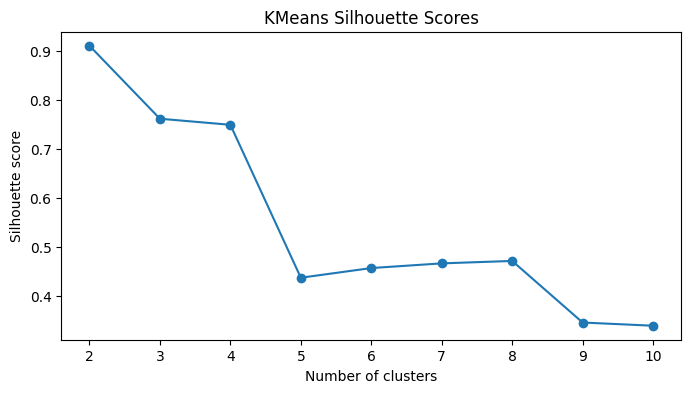

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Test different cluster numbers
range_n = range(2, 11)
kmeans_scores = []

for n in range_n:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    kmeans_scores.append(score)
    print(f"KMeans: n_clusters={n}, silhouette_score={score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range_n, kmeans_scores, marker='o')
plt.title('KMeans Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


### Step 3: Apply KMeans with Optimal Cluster Number

Based on silhouette scores, we will apply KMeans with 2 and 3 clusters.  
We will examine the cluster sizes and visualize them in 2D.


In [7]:
# Apply KMeans with 2 and 3 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

# Add cluster labels to the dataframe
df['Cluster_2'] = kmeans_2.labels_
df['Cluster_3'] = kmeans_3.labels_

# Check cluster sizes
print("Cluster sizes (2 clusters):")
print(df['Cluster_2'].value_counts())

print("\nCluster sizes (3 clusters):")
print(df['Cluster_3'].value_counts())


Cluster sizes (2 clusters):
Cluster_2
0    4300
1      15
Name: count, dtype: int64

Cluster sizes (3 clusters):
Cluster_3
0    4195
2     112
1       8
Name: count, dtype: int64


### Step 4: Visualize KMeans Clusters

We will use PCA (Principal Component Analysis) to reduce the scaled features to 2D and plot the clusters to examine their separation.


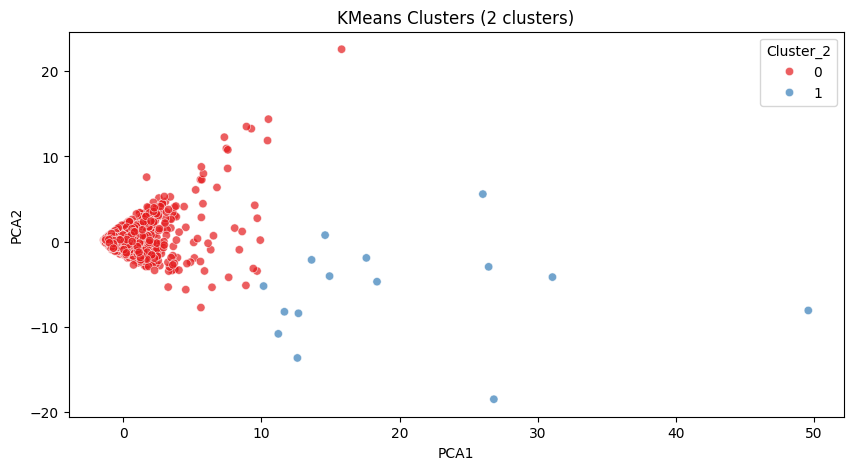

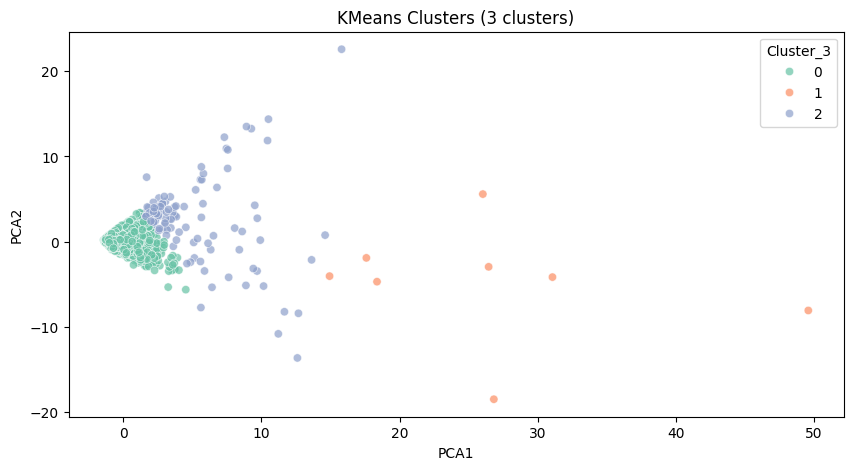

In [8]:
from sklearn.decomposition import PCA

# Reduce to 2 components for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

# Plot 2-cluster solution
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_2', palette='Set1', alpha=0.7)
plt.title('KMeans Clusters (2 clusters)')
plt.show()

# Plot 3-cluster solution
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_3', palette='Set2', alpha=0.7)
plt.title('KMeans Clusters (3 clusters)')
plt.show()


### Note on Feature Selection Adjustment

In our initial clustering attempt, we used an extended feature set including engineered variables like AvgBasketSize, AvgOrderValue, and MonetaryPerItem.  
However, we found that the clustering algorithms (KMeans, Hierarchical) mostly isolated a small number of outliers, leaving one overwhelmingly large cluster.


We will now pivot to this approach:
- Use only Recency, Frequency, and Monetary.
- Apply outlier filtering.
- Rerun clustering and evaluation.


In [9]:
# Reload the data
data_path = '../outputs/customer_features_final.csv'
df = pd.read_csv(data_path)

# Select only core RFM features
rfm_features = ['Recency', 'Frequency', 'Monetary']
X_rfm = df[rfm_features].copy()

# Check initial shape and summary
print(f"Initial RFM shape: {X_rfm.shape}")
print(X_rfm.describe())

# Filter out top 1% outliers in each column
quantile_threshold = 0.99
for col in rfm_features:
    threshold = X_rfm[col].quantile(quantile_threshold)
    X_rfm = X_rfm[X_rfm[col] <= threshold]
    print(f"After filtering {col} at 99th percentile, shape: {X_rfm.shape}")

# Scale the features
scaler = StandardScaler()
X_rfm_scaled = scaler.fit_transform(X_rfm)

print(f"Scaled RFM shape: {X_rfm_scaled.shape}")


Initial RFM shape: (4315, 3)
           Recency    Frequency       Monetary
count  4315.000000  4315.000000    4315.000000
mean     90.349942     5.119583    1926.380870
std      99.162620     9.384195    8269.509136
min       1.000000     1.000000       2.900000
25%      17.000000     1.000000     302.895000
50%      49.000000     3.000000     658.260000
75%     138.000000     6.000000    1627.625000
max     374.000000   248.000000  279489.020000
After filtering Recency at 99th percentile, shape: (4272, 3)
After filtering Frequency at 99th percentile, shape: (4229, 3)
After filtering Monetary at 99th percentile, shape: (4186, 3)
Scaled RFM shape: (4186, 3)


In [10]:
# Run KMeans for 3, 4, 5 clusters
range_n = [3, 4, 5]
for n in range_n:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X_rfm_scaled)
    score = silhouette_score(X_rfm_scaled, labels)
    cluster_sizes = np.bincount(labels)
    print(f"KMeans n_clusters={n}, silhouette_score={score:.4f}, cluster sizes={cluster_sizes}")


KMeans n_clusters=3, silhouette_score=0.5077, cluster sizes=[2701 1016  469]
KMeans n_clusters=4, silhouette_score=0.4789, cluster sizes=[ 817 2174  225  970]
KMeans n_clusters=5, silhouette_score=0.4180, cluster sizes=[ 767  703  215  577 1924]


### Step 8: Visualize KMeans Clusters 

We will apply PCA to reduce the data to 2D and plot the cluster assignments  
to visually assess the separation and structure of the customer groups.


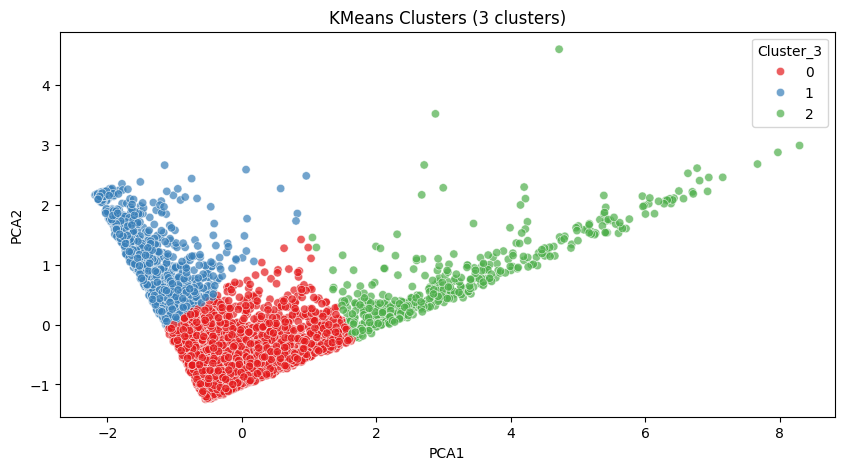

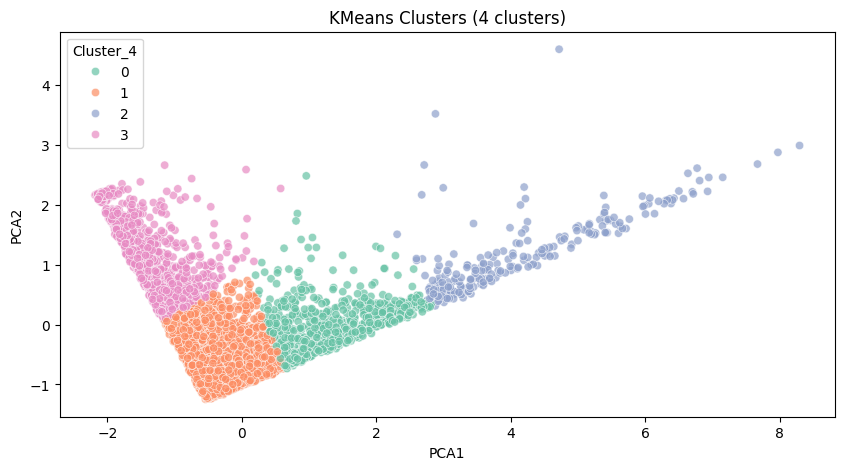

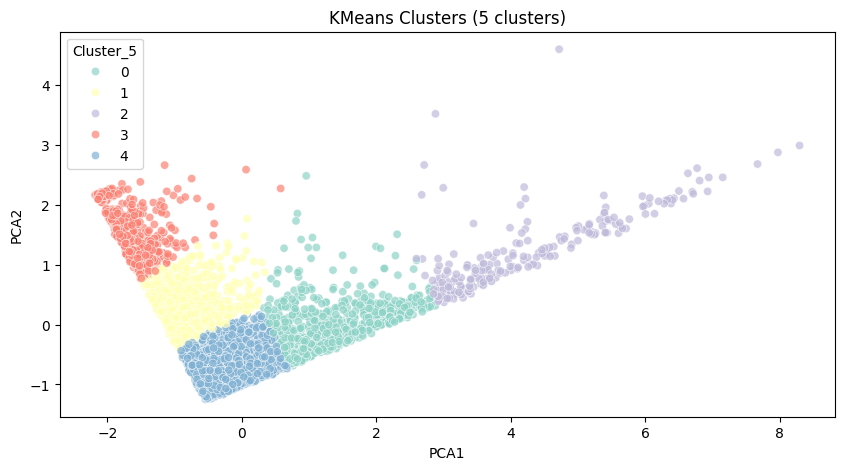

In [12]:
# Create a copy of the filtered X_rfm dataframe (4186 rows)
df_rfm_clusters = X_rfm.copy()
df_rfm_clusters = df_rfm_clusters.reset_index(drop=True)

# Add cluster labels
df_rfm_clusters['Cluster_3'] = kmeans_3.labels_
df_rfm_clusters['Cluster_4'] = kmeans_4.labels_
df_rfm_clusters['Cluster_5'] = kmeans_5.labels_

# Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_rfm_scaled)
df_rfm_clusters['PCA1'] = components[:, 0]
df_rfm_clusters['PCA2'] = components[:, 1]

# Plot 3-cluster solution
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_rfm_clusters, x='PCA1', y='PCA2', hue='Cluster_3', palette='Set1', alpha=0.7)
plt.title('KMeans Clusters (3 clusters)')
plt.show()

# Plot 4-cluster solution
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_rfm_clusters, x='PCA1', y='PCA2', hue='Cluster_4', palette='Set2', alpha=0.7)
plt.title('KMeans Clusters (4 clusters)')
plt.show()

# Plot 5-cluster solution
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_rfm_clusters, x='PCA1', y='PCA2', hue='Cluster_5', palette='Set3', alpha=0.7)
plt.title('KMeans Clusters (5 clusters)')
plt.show()


### Step 9: Profile and Interpret Clusters

We will calculate the mean and median RFM values for each cluster  
to understand the behavioral differences between the customer segments.


In [13]:
# Group and summarize by 3-cluster solution
profile_3 = X_rfm.copy()
profile_3['Cluster'] = df_rfm_clusters['Cluster_3']
summary_3 = profile_3.groupby('Cluster').agg(['mean', 'median', 'count'])
print("Cluster 3 summary:")
print(summary_3)

# Group and summarize by 4-cluster solution
profile_4 = X_rfm.copy()
profile_4['Cluster'] = df_rfm_clusters['Cluster_4']
summary_4 = profile_4.groupby('Cluster').agg(['mean', 'median', 'count'])
print("\nCluster 4 summary:")
print(summary_4)


Cluster 3 summary:
           Recency              Frequency                  Monetary           \
              mean median count      mean median count         mean   median   
Cluster                                                                        
0.0      87.647104   50.0  2624  4.281631    3.0  2624  1257.026590  649.955   
1.0      93.450203   51.0   984  4.225610    2.0   984  1216.889616  622.040   
2.0      88.427938   47.0   451  4.818182    3.0   451  1406.217007  733.890   

               
        count  
Cluster        
0.0      2624  
1.0       984  
2.0       451  

Cluster 4 summary:
           Recency              Frequency                  Monetary          \
              mean median count      mean median count         mean  median   
Cluster                                                                       
0.0      86.263625   47.0   789  4.619772    3.0   789  1319.176364  690.54   
1.0      88.068150   50.0  2113  4.238050    3.0  2113  1250.255983 

### Step 10: Save Clustered Dataset

We will save the filtered RFM dataset with the 4-cluster labels.  
This will be used for classification and regression tasks in the next modeling phase.


In [14]:
# Prepare dataset to save
df_rfm_clusters_to_save = X_rfm.copy().reset_index(drop=True)
df_rfm_clusters_to_save['Cluster_4'] = df_rfm_clusters['Cluster_4']

# Save to outputs folder
output_path = '../outputs/customer_rfm_clusters.csv'
df_rfm_clusters_to_save.to_csv(output_path, index=False)

print(f"Clustered dataset saved to: {output_path}")
print(df_rfm_clusters_to_save.head())


Clustered dataset saved to: ../outputs/customer_rfm_clusters.csv
   Recency  Frequency  Monetary  Cluster_4
0        2          7   4310.00          0
1       75          4   1797.24          1
2       19          1   1757.55          1
3      310          1    334.40          3
4       36         11   1545.41          0


### Step 11: Reload Clustered Dataset for Modeling

We reload the saved clustered dataset to start fresh  
and prepare for classification and regression tasks.


In [15]:
# Reload clustered data
clustered_data_path = '../outputs/customer_rfm_clusters.csv'
df_model = pd.read_csv(clustered_data_path)

print(f"Reloaded dataset shape: {df_model.shape}")
print(df_model.head())


Reloaded dataset shape: (4186, 4)
   Recency  Frequency  Monetary  Cluster_4
0        2          7   4310.00          0
1       75          4   1797.24          1
2       19          1   1757.55          1
3      310          1    334.40          3
4       36         11   1545.41          0


In [17]:
# Load extended features
features_path = '../outputs/customer_features_final.csv'
df_features = pd.read_csv(features_path)

# Merge with cluster dataset
df_full = pd.merge(df_model, df_features, on=['Recency', 'Frequency', 'Monetary'], how='left')

print(f"Merged dataset shape: {df_full.shape}")
print(df_full.head())


Merged dataset shape: (4186, 11)
   Recency  Frequency  Monetary  Cluster_4  CustomerID  TotalQuantity  \
0        2          7   4310.00          0     12347.0           2458   
1       75          4   1797.24          1     12348.0           2341   
2       19          1   1757.55          1     12349.0            631   
3      310          1    334.40          3     12350.0            197   
4       36         11   1545.41          0     12352.0            470   

   AvgBasketSize  AvgOrderValue  MonetaryPerItem RecencyBucket FrequencyBucket  
0     351.142857     615.714286         1.753458        Recent          Medium  
1     585.250000     449.310000         0.767723           Mid          Medium  
2     631.000000    1757.550000         2.785341        Recent             Low  
3     197.000000     334.400000         1.697462           Old             Low  
4      42.727273     140.491818         3.288106           Mid            High  


### Step 13: Prepare Features for Modeling

We will select numeric and categorical features,  
apply one-hot encoding to the bucket columns,  
and prepare the data for classification and regression models.


In [18]:
# One-hot encode categorical buckets
df_model_final = pd.get_dummies(df_full, columns=['RecencyBucket', 'FrequencyBucket'], drop_first=True)

# Drop identifiers and target from X
X = df_model_final.drop(columns=['CustomerID', 'Cluster_4'])

# Classification target
y_class = df_model_final['Cluster_4']

print(f"Feature matrix shape: {X.shape}")
print(f"Target (classification) shape: {y_class.shape}")


Feature matrix shape: (4186, 11)
Target (classification) shape: (4186,)


### Step 14: Train/Test Split for Classification

We will split the data into training and testing sets,  
ensuring that the cluster distribution is preserved using stratification.


In [19]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2930, 11), Test shape: (1256, 11)


### Step 17: Train and Evaluate Random Forest and Logistic Regression

We will train both models and compare their performance using  
accuracy, precision, recall, F1 score, and the confusion matrix.


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize models
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

# Train models
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

# Predict
rf_preds = rf.predict(X_test)
lr_preds = lr.predict(X_test)

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

# Evaluate Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       245
           1       0.98      0.99      0.99       652
           2       0.95      0.93      0.94        68
           3       0.99      0.98      0.99       291

    accuracy                           0.98      1256
   macro avg       0.97      0.96      0.97      1256
weighted avg       0.98      0.98      0.98      1256

Random Forest Confusion Matrix:
[[234   6   3   2]
 [  4 647   0   1]
 [  5   0  63   0]
 [  0   5   0 286]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       245
           1       0.94      0.93      0.93       652
           2       0.83      0.88      0.86        68
           3       0.93      0.97      0.95       291

    accuracy                           0.92      1256
   macro avg       0.89      0.90      0.90      

c:\Users\Tarık Buğra Ay\Desktop\BI_PROJECT\env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Step 18: Visualize Random Forest Results

We will plot feature importances and the confusion matrix  
to better understand model behavior and evaluate performance.


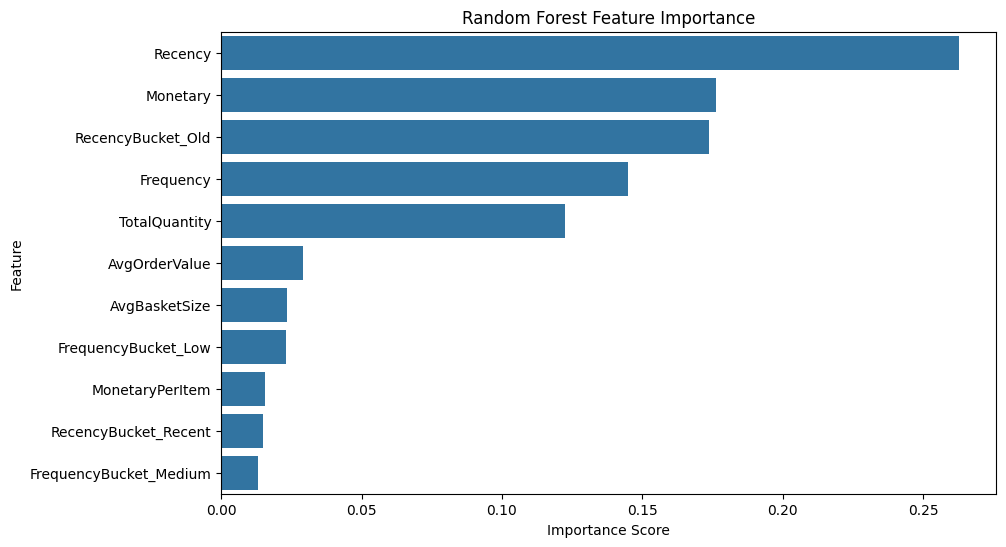

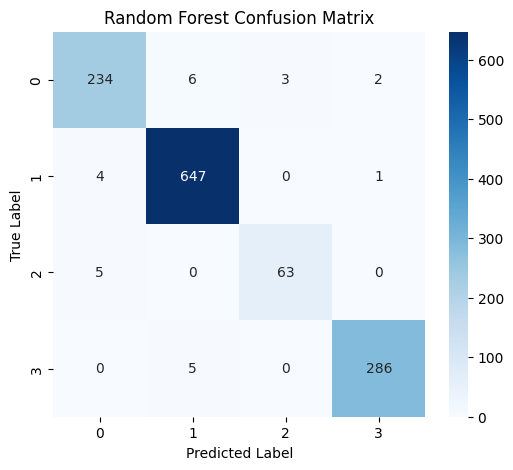

In [21]:
importances = rf.feature_importances_
feature_names = X.columns

# Feature importance plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Confusion matrix heatmap
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_class), yticklabels=np.unique(y_class))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Step 19: Plot ROC AUC Curves and Calculate Gini Index

We will plot the ROC AUC curves for each class using a One-vs-Rest approach  
and calculate the Gini Index to evaluate model separation power.


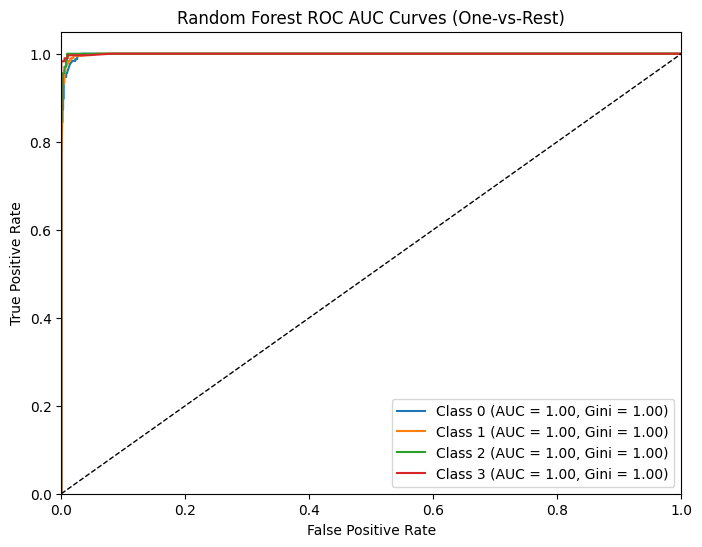

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for OvR
y_test_bin = label_binarize(y_test, classes=np.unique(y_class))
n_classes = y_test_bin.shape[1]
rf_probs = rf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
gini_index = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    gini_index[i] = 2 * roc_auc[i] - 1


# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f}, Gini = {gini_index[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC AUC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


### Step 20: Regression Modeling — Predict Monetary

We will train regression models to predict customer Monetary value  
using the full feature set, excluding Monetary itself as a predictor.


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Prepare regression features
X_reg = df_model_final.drop(columns=['CustomerID', 'Monetary', 'Cluster_4'])
y_reg = df_model_final['Monetary']

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Initialize models
rf_reg = RandomForestRegressor(random_state=42)
lr_reg = LinearRegression()

# Train models
rf_reg.fit(X_train_reg, y_train_reg)
lr_reg.fit(X_train_reg, y_train_reg)

# Predict
rf_preds_reg = rf_reg.predict(X_test_reg)
lr_preds_reg = lr_reg.predict(X_test_reg)

# Evaluate function
def evaluate_regression(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} → R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Evaluate Random Forest
evaluate_regression(y_test_reg, rf_preds_reg, "Random Forest Regressor")

# Evaluate Linear Regression
evaluate_regression(y_test_reg, lr_preds_reg, "Linear Regression")


Random Forest Regressor → R²: 0.9749, MAE: 50.69, RMSE: 239.91
Linear Regression → R²: 0.8672, MAE: 242.55, RMSE: 552.15


### Step 21: Visualize Regression Results

We will plot predicted vs. actual Monetary values and examine feature importances  
to understand model behavior and interpretation.


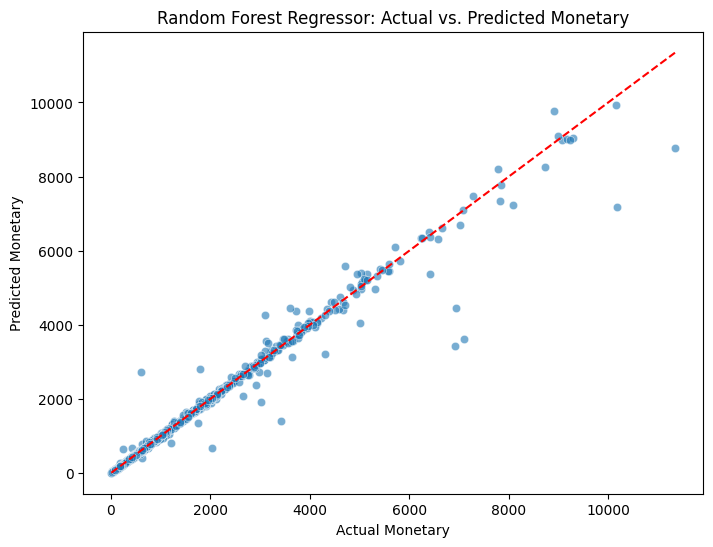

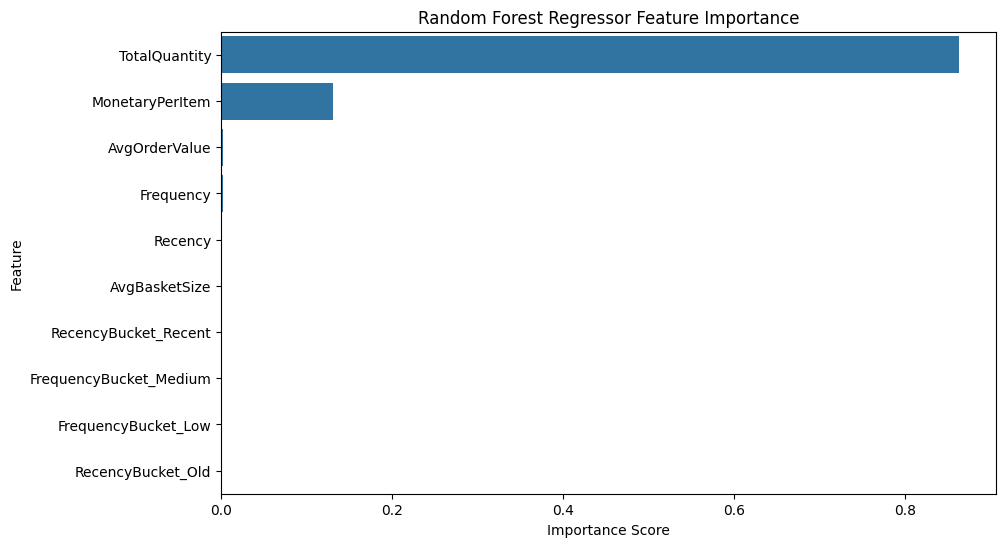

In [26]:
# Plot Predicted vs. Actual (Random Forest)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_reg, y=rf_preds_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel('Actual Monetary')
plt.ylabel('Predicted Monetary')
plt.title('Random Forest Regressor: Actual vs. Predicted Monetary')
plt.show()

# Feature importance
rf_reg_importances = rf_reg.feature_importances_
feat_imp_reg = pd.Series(rf_reg_importances, index=X_reg.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp_reg.values, y=feat_imp_reg.index)
plt.title('Random Forest Regressor Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
